In [2]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import google.generativeai as genai
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
import os
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.environ['GOOGLE_API_KEY'] = 'API_KEY'
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.3,  convert_system_message_to_human=True)

In [4]:
"""
# Cell 3: Load and preprocess arXiv data
def load_arxiv_data(file_path, field="cs"):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    
    df = pd.DataFrame(data)
    # Filter for specified field
    df = df[df['categories'].str.contains(field, case=False)]
    
    # Combine title and abstract for better context
    df['content'] = df['title'] + '\n\n' + df['abstract']
    return df

# Load data
arxiv_data = load_arxiv_data("../Dataset/arxiv-metadata-oai-snapshot.json")
print(f"Loaded {len(arxiv_data)} papers")

"""

'\n# Cell 3: Load and preprocess arXiv data\ndef load_arxiv_data(file_path, field="cs"):\n    with open(file_path, \'r\') as f:\n        data = [json.loads(line) for line in f]\n    \n    df = pd.DataFrame(data)\n    # Filter for specified field\n    df = df[df[\'categories\'].str.contains(field, case=False)]\n    \n    # Combine title and abstract for better context\n    df[\'content\'] = df[\'title\'] + \'\n\n\' + df[\'abstract\']\n    return df\n\n# Load data\narxiv_data = load_arxiv_data("../Dataset/arxiv-metadata-oai-snapshot.json")\nprint(f"Loaded {len(arxiv_data)} papers")\n\n'

In [5]:
VECTOR_DB_PATH = "../faiss_db"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  
embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)

In [6]:
# ✅ Load FAISS Vector Database
def load_vector_db():
    print("Loading FAISS vector database...")
    return FAISS.load_local(VECTOR_DB_PATH, embeddings, allow_dangerous_deserialization=True)

In [7]:
vector_store = load_vector_db()

Loading FAISS vector database...


In [8]:
#  Setup conversation memory and QA chain
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer" 
)

qa_chain = ConversationalRetrievalChain.from_llm(
    llm=model,
    retriever=vector_store.as_retriever(),
    memory=memory,
    return_source_documents=True,
    verbose=True,  # Add this for debugging
    chain_type="stuff"  # Specify chain type
)

In [9]:
# Cell 8: Function for paper summarization (Outcome 1)
def summarize_paper(paper_title: str):
    """Generate summary for a specific paper"""
    # Find the paper
    results = vector_store.similarity_search(paper_title, k=1)
    if results:
        paper_content = results[0].page_content
        
        # Create summary prompt
        summary_prompt = f"""
        Please provide a comprehensive summary of this research paper:
        {paper_content}
        
        Include:
        1. Main objectives
        2. Key findings
        3. Methodology
        4. Conclusions
        """
        
        # Generate summary using Gemini
        summary = model.invoke(summary_prompt)
        return summary
    return "Paper not found"

In [10]:
# Cell 9: Chat function (Outcomes 1, 2, and 3)
def chat_with_expert(query: str):
    """
    Chat with the expert system - handles:
    - Advanced topic discussion (Outcome 1)
    - Complex concept explanation (Outcome 2)
    - Follow-up questions (Outcome 3)
    """
    result = qa_chain({"question": query})
    
    response = {
        "answer": result["answer"],
        "source_papers": [doc.page_content.split('\n\n')[0] for doc in result["source_documents"]]
    }
    
    print("Answer:", response["answer"])
    print("\nRelevant Papers:")
    for i, paper in enumerate(response["source_papers"], 1):
        print(f"{i}. {paper}")
    
    return response

In [11]:
print("Testing advanced topic discussion...")
chat_with_expert("What are the latest developments in transformer models?")

Testing advanced topic discussion...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
compared the existing transformers with the transformers obtained using AMURTH,
we discovered that four of the existing transformers were unsound, which
demonstrates the risk of using manually created transformers.
Categories: cs.PL
ID: 2105.00493

byte-level Transformer models based on the T5 architecture, as well as all code
and data used in our experiments.
Categories: cs.CL
ID: 2105.13626

Title: Are Pre-trained Convolutions Better than Pre-trained Transformers?
Authors: Yi Tay, Mostafa Dehghani, Jai Gupta, Dara Bahri, Vamsi Aribandi, Zhen
  Qin, Donald Metzler
Abstract: In the era of pre-trained language models, Transformers are the de facto
choice of model a

{'answer': 'Based on the provided abstracts, there are several recent developments in transformer models:\n\n* **Improved Transformer Creation Methods:**  One study found that manually created transformers are risky, as four out of an unspecified number were found to be "unsound" when compared to transformers created using a method called AMURTH (2105.00493).  The specifics of AMURTH are not detailed.\n\n* **Byte-Level Transformer Models:**  Research has explored byte-level transformer models based on the T5 architecture (2105.13626).\n\n* **Comparison of Pre-trained Convolutions and Transformers:** A study compared pre-trained convolutional neural networks (CNNs) with pre-trained transformers, finding that CNNs were competitive and even outperformed transformers in some scenarios (2105.03322).  This suggests that architectural advances should be considered independently from pre-training techniques.\n\n* **Transformer Models for Noisy Speech Data:**  Work has been done to develop tran

In [12]:
print("\nTesting complex concept explanation...")
chat_with_expert("Explain the concept of attention mechanism in deep learning")


Testing complex concept explanation...


> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:

Human: What are the latest developments in transformer models?
Assistant: Based on the provided abstracts, there are several recent developments in transformer models:

* **Improved Transformer Creation Methods:**  One study found that manually created transformers are risky, as four out of an unspecified number were found to be "unsound" when compared to transformers created using a method called AMURTH (2105.00493).  The specifics of AMURTH are not detailed.

* **Byte-Level Transformer Models:**  Research has explored byte-level transformer models based on the T5 architecture (2105.13626).

* **Comparison of Pre-trained Convolutions and Transformers:** A study compared pre-trained convolutional neural networks (CNNs) with pre-

{'answer': 'Based on the provided text, attention mechanisms in deep learning are used to weigh the importance of different parts of the input data when generating an output.  Several types are mentioned:\n\n* **Self-attention:**  This mechanism weighs the importance of different parts *within a single input sample*.  It captures long-range dependencies but has quadratic complexity.\n\n* **External attention:** This mechanism uses shared, learnable memories (implemented with linear layers) to weigh the importance of different parts of the input, implicitly considering correlations *between different samples*. It has linear complexity.\n\n* **Hierarchical attention:** This mechanism is used to process hierarchical data, such as in video question answering.\n\nThe papers also discuss how attention mechanisms can be used for interpretability (analyzing *effective attention* to understand model behavior) and knowledge distillation (using attention to understand how knowledge is transferred

In [13]:
print("\nTesting follow-up question handling...")
chat_with_expert("What are its advantages?")  # Follow-up about attention mechanism


Testing follow-up question handling...


> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:

Human: What are the latest developments in transformer models?
Assistant: Based on the provided abstracts, there are several recent developments in transformer models:

* **Improved Transformer Creation Methods:**  One study found that manually created transformers are risky, as four out of an unspecified number were found to be "unsound" when compared to transformers created using a method called AMURTH (2105.00493).  The specifics of AMURTH are not detailed.

* **Byte-Level Transformer Models:**  Research has explored byte-level transformer models based on the T5 architecture (2105.13626).

* **Comparison of Pre-trained Convolutions and Transformers:** A study compared pre-trained convolutional neural networks (CNNs) with pre-

{'answer': 'Based on the provided text, attention mechanisms in vision transformers allow for flexible attention to a sequence of image patches to encode contextual cues.  This flexibility facilitates handling nuisances in natural images such as occlusions, domain shifts, and perturbations.  One study showed that vision transformers retain high accuracy even with 80% of an image randomly occluded.  However, another study questions the reliability of using attention weights as a measure of salience, finding disagreement between attention-based explanations and other explanation methods.',
 'source_papers': ['Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does\n  Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nAbstract: The strong performance of vision transformers on image classification and\nother vision tasks is often attributed to the design of their multi-head\nattention layers. However, the extent to which attention is responsible for\nthis strong per

In [14]:
def search_papers(query: str, n_results: int = 5):
    """Search for relevant papers in the vector store"""
    results = vector_store.similarity_search(query, k=n_results)

    if not results:
        print("No relevant papers found.")
        return []

    papers = []
    for doc in results:
        content = doc.page_content.strip()  # Remove leading/trailing spaces
        lines = content.split("\n")  # Split into lines instead of "\n\n"
        
        title, abstract = "No Title Available", "No Abstract Available"
        
        # Try to extract title properly
        for line in lines:
            if line.lower().startswith("title:"):
                title = line.replace("Title:", "").strip()
            elif line.lower().startswith("abstract:"):
                abstract = line.replace("Abstract:", "").strip()
                break  # Stop after finding the first abstract
        
        papers.append({"title": title, "abstract": abstract})
    
    return papers

In [15]:
# Testing
print("\nTesting paper search...")
papers = search_papers("reinforcement learning")
print("Papers Found:", papers)


Testing paper search...
Papers Found: [{'title': 'No Title Available', 'abstract': 'No Abstract Available'}, {'title': 'Reinforcement Learning with Expert Trajectory For Quantitative Trading', 'abstract': 'In recent years, quantitative investment methods combined with artificial'}, {'title': 'What is Going on Inside Recurrent Meta Reinforcement Learning Agents?', 'abstract': 'Recurrent meta reinforcement learning (meta-RL) agents are agents that employ'}, {'title': 'Efficient PAC Reinforcement Learning in Regular Decision Processes', 'abstract': 'Recently regular decision processes have been proposed as a well-behaved form'}, {'title': 'No Title Available', 'abstract': 'No Abstract Available'}]


In [16]:
# Cell 7: Function for concept visualization (Outcome 4)
def visualize_concepts(query: str):
    """Create concept visualization for a given topic"""
    papers = search_papers(query, n_results=10)
    
    vectorizer = CountVectorizer(max_features=10, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform([p['abstract'] for p in papers])
    terms = vectorizer.get_feature_names_out()
    
    G = nx.Graph()
    G.add_node(query, size=3000)
    for term in terms:
        G.add_node(term, size=1000)
        G.add_edge(query, term)
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=[G.nodes[node]['size'] for node in G.nodes],
            font_size=10, font_weight='bold')
    plt.title(f"Concept Map for: {query}")
    plt.show()

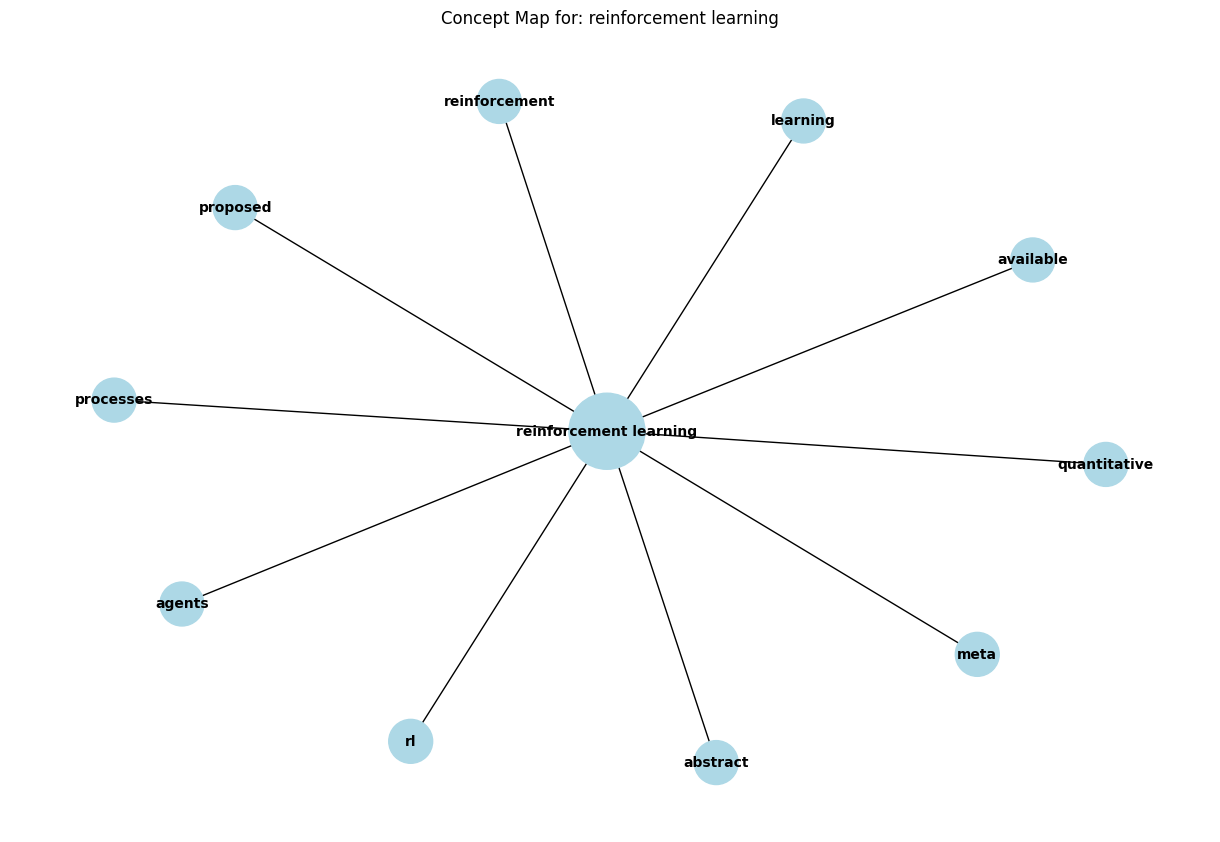

In [17]:
visualize_concepts("reinforcement learning")

In [18]:
print("\nTesting complex concept explanation...")
summarize_paper("Summarize the concept of attention mechanism ")


Testing complex concept explanation...


AIMessage(content='This research paper, "Effective Attention Sheds Light On Interpretability," by Kaiser Sun and Ana Marasovi\\\'c, investigates the interpretability of attention mechanisms in transformer models, specifically focusing on BERT.\n\n**1. Main Objectives:** The primary objective is to determine whether visualizing "effective attention" – a component of the standard attention matrix proven to be solely responsible for influencing model output – provides a more insightful interpretation of a transformer\'s behavior compared to visualizing the standard attention matrix.  The researchers aim to show that standard attention can be misleading due to the inclusion of irrelevant information.\n\n**2. Key Findings:** The authors demonstrate that standard and effective attention matrices yield different interpretations.  They find that standard attention is more strongly associated with artifacts from the language modeling pre-training phase, such as the separator token, while effect

In [19]:
import plotly.graph_objects as go

In [20]:
def visualize_concepts(query: str) -> go.Figure:
    """Generate an improved concept visualization graph."""
    try:
        papers = search_papers(query, n_results=10)
        if not papers:
            raise ValueError("No papers found for visualization")

        vectorizer = CountVectorizer(
            max_features=10,
            stop_words='english',
            min_df=2
        )
        
        abstracts = [p['abstract'] for p in papers]
        doc_term_matrix = vectorizer.fit_transform(abstracts)
        terms = vectorizer.get_feature_names_out()

        # Create network graph
        G = nx.Graph()
        G.add_node(query, size=20, color='red')
        for term in terms:
            G.add_node(term, size=15, color='blue')
            G.add_edge(query, term)

        pos = nx.spring_layout(G)
        
        # Create Plotly figure
        fig = go.Figure()
        
        # Add edges
        edge_x = []
        edge_y = []
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines'
        ))

        # Add nodes
        node_x = []
        node_y = []
        node_text = []
        node_size = []
        node_color = []
        
        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_text.append(node)
            node_size.append(G.nodes[node]['size'])
            node_color.append(G.nodes[node]['color'])
            
        fig.add_trace(go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            hoverinfo='text',
            text=node_text,
            textposition='top center',
            marker=dict(
                size=node_size,
                color=node_color,
                line_width=2
            )
        ))
        
        fig.update_layout(
            title=f"Concept Map for: {query}",
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40)
        )
        
        return fig
    except Exception as e:
        # Return a basic figure with error message
        fig = go.Figure()
        fig.add_annotation(
            text=f"Error generating visualization: {str(e)}",
            xref="paper", yref="paper",
            x=0.5, y=0.5, showarrow=False
        )
        return fig

In [21]:
visualize_concepts("reinforcement learning")